In [1]:
algo = catalog.load('votos_segmentados')

2022-03-08 21:50:47,296 - kedro.io.data_catalog - INFO - Loading data from `votos_segmentados` (PickleDataSet)...


In [3]:
algo[0]

{'nombre': '2100100001X',
 'votos': [{'diputados': [array([[255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           ...,
           [255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)],
   'senadores': [array([[255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           ...,
           [255, 255, 255, ..., 212, 255, 255],
           [255, 255, 255, ..., 223, 255, 255],
           [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]},
  {'diputados': [array([[255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           ...,
           [255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..

In [4]:
from PIL import Image
import cv2 
from IPython.display import display

def imgshow(img) -> None:
    display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

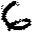

In [7]:
imgshow(algo[0]['votos'][1]['diputados'][0])